## Using Qiskit Aqua and RevKit for Grover search oracle synthesis

We implement a new oracle by subclassing `Oracle`.  This oracle, called `BooleanExpression`, takes as input a Boolean expression given as a string and creates the quantum circuit for it.

A Boolean expression `E` can either be
* a variable `a`, `b`, ..., `p`,
* a negation of an expression `!E`,
* a conjunction of expressions `(E...E)`,
* a disjunction of expressions `{E...E}`,
* a exclusive or of expressions `[E...E]`, or
* the majority of three expressions `<EEE>`.

In [1]:
import operator
import revkit
from qiskit import QuantumCircuit, QuantumRegister, load_qasm_string
from qiskit.wrapper._circuittoolkit import circuit_from_qasm_string
from qiskit_aqua.algorithms.components.oracles import Oracle

In [2]:
class BooleanExpression(Oracle):
    BE_CONFIGURATION = {
        'name': 'BooleanExpression',
        'description': 'Boolean expression oracle',
        'input_schema': {
            '$schema': 'http://json-schema.org/schema#',
            'id': 'boolean_expression_oracle_schema',
            'type': 'object',
            'properties': {
                'expr': {
                    'type': 'string'
                },
                'strategy': {
                    'type': 'integer',
                    'default': 1
                }
            },
            'additionalProperties': False
        }
    }
    
    def __init__(self, configuration=None):
        super().__init__(configuration or self.BE_CONFIGURATION.copy())
        self._expr = None
        self._strategy = None
        self._vars = None
        self._binary = None
        self._qr_outcome = None
        self._qr_variable = None
        self._qr_ancilla = None
        
    def init_args(self, expr, strategy):
        # create truth table from expression
        self._expr = expr
        self._strategy = strategy
        revkit.tt(expression=expr)
        
        # read number of variables and expression as binary string
        log = revkit.ps(tt=True, silent=True)
        self._vars = log['vars']
        self._binary = log['binary']

        self._qr_outcome = QuantumRegister(1, name='o')
        self._qr_variable = QuantumRegister(self._vars, name='v')
        num_ancillae = 1 if self._vars > 2 else 0
        if num_ancillae > 0:
            self._qr_ancilla = QuantumRegister(num_ancillae, name='a')
            
    
    def variable_register(self):
        return self._qr_variable
    
    def ancillary_register(self):
        return self._qr_ancilla
    
    def outcome_register(self):
        return self._qr_outcome
    
    def construct_circuit(self):
        revkit.stg(stg=self._strategy)
        if self._strategy == 0:
            return self.load_from_qasm(revkit.to_qasm(mct=True))
        else:
            return self.load_from_qasm(revkit.to_qasm(qc=True))
    
    def load_from_qasm(self, qasm):
        from qiskit.qasm import Qasm
        from qiskit.unroll import Unroller, CircuitBackend
        
        class IntoCircuitBackend(CircuitBackend):
            def __init__(self, qc):
                super().__init__("id,u0,u1,u2,u3,x,y,z,h,s,sdg,t,tdg,rx,ry,rz,cx,cy,cz,ch,crz,cu1,cu3,swap,ccx,cswap".split(","))
                self.circuit = qc
                
            def new_qreg(self, name, size):
                pass

        if self._qr_ancilla:
            qc = QuantumCircuit(self._qr_variable, self._qr_ancilla, self._qr_outcome)
        else:
            qc = QuantumCircuit(self._qr_variable, self._qr_outcome)
        node_circuit = Qasm(data=self._rename_registers(qasm)).parse()
        unrolled_circuit = Unroller(node_circuit, IntoCircuitBackend(qc))
        return unrolled_circuit.execute()
        
    
    def _rename_registers(self, qasm):
        qasm = qasm.replace(f"qreg q[{self._vars + 1}];\ncreg c[{self._vars + 1}];\n", f"qreg v[{self._vars}];\nqreg o[1];\n")
        for i in range(self._vars):
            qasm = qasm.replace(f"q[{i}]", f"v[{i}]")
        qasm = qasm.replace(f"q[{self._vars}]", "o[0]")
        return qasm

    def evaluate_classically(self, assignment):
        return sum(2**i if a else 0 for i, a in enumerate(assignment))
    
    def interpret_measurement(self, measurement, *args, **kwargs):
        top_measurement = max(measurement.items(), key=operator.itemgetter(1))[0]
        return [bool(int(tf)) for tf in top_measurement[::-1]]

Now the above oracle can be used together with a Grover search inside Qiskit Aqua.

In [3]:
import pylab
from qiskit_aqua import run_algorithm, refresh_pluggables
from qiskit_aqua._discover import register_pluggable, _REGISTERED_PLUGGABLES
from qiskit.tools.visualization import circuit_drawer, plot_histogram

In [4]:
if 'oracle' in _REGISTERED_PLUGGABLES:
    _REGISTERED_PLUGGABLES['oracle'].pop('BooleanExpression', None)
register_pluggable(BooleanExpression)

'BooleanExpression'

In [5]:
algorithm_cfg = {
    'name': 'Grover'
}

oracle_cfg = {
    'name': 'BooleanExpression',
    'expr': '[![abc]<abc>]',
    'strategy': 0
}

params = {
    'problem': {'name': 'search', 'random_seed': 50},
    'algorithm': algorithm_cfg,
    'oracle': oracle_cfg,
    'backend': {'name': 'qasm_simulator'}
}

result = run_algorithm(params)
print(result['result'])

[True, True, True]


In [6]:
print(result['circuit'].qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg v[3];
qreg a[1];
creg m[3];
qreg o[1];
h v[0];
h v[1];
h v[2];
ccx v[0],v[1],o[0];
ccx v[0],v[2],o[0];
cx v[0],o[0];
ccx v[1],v[2],o[0];
cx v[1],o[0];
cx v[2],o[0];
x o[0];
h v[0];
h v[1];
h v[2];
x v[0];
x v[1];
x v[2];
x o[0];
h o[0];
ccx v[0],v[1],a[0];
ccx v[2],a[0],o[0];
ccx v[0],v[1],a[0];
h o[0];
x v[0];
x v[1];
x v[2];
x o[0];
h v[0];
h v[1];
h v[2];
h o[0];
measure v[0] -> m[0];
measure v[1] -> m[1];
measure v[2] -> m[2];



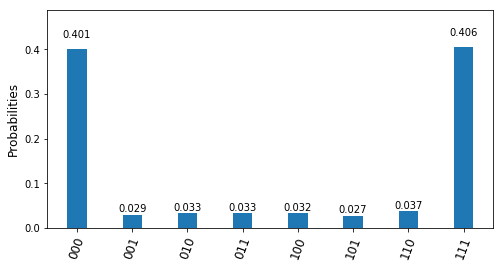

In [7]:
pylab.rcParams['figure.figsize'] = (8, 4)
plot_histogram(result['measurements'])